In [108]:
pip install mysql-connector-python


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'e:\아경\AI\Python38\python.exe -m pip install --upgrade pip' command.


### 1. Imports 및 클래스 정의

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import concurrent.futures
from tqdm import tqdm
# from sqlalchemy import create_engine
import pymysql
import datetime
import random
import configparser
from cryptography.fernet import Fernet
import mysql.connector
from datetime import timedelta
import numpy as np

class Position:
    def __init__(self, buy_price, quantity,order,additional_buy_drop_rate,sell_profit_rate):
        self.buy_price = buy_price
        self.quantity = quantity
        self.order = order  # 포지션의 차수
        self.additional_buy_drop_rate = additional_buy_drop_rate  
        self.sell_profit_rate = sell_profit_rate 



### 2. 롤링 윈도우 계산 함수

In [110]:

# 데이터베이스에서 조건을 만족하는 종목을 동적으로 가져오는 함수
def get_stock_codes(date, per_threshold, pbr_threshold, div_threshold, normalized_value_threshold, db_params):
    # 데이터베이스 연결
    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    # 날짜 형식 변환
    date_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    # SQL 쿼리 실행
    query = f"""
    SELECT ticker 
    FROM stock_data 
    WHERE date = '{date_str}' 
    AND PER > 0 
    AND PER <= {per_threshold} 
    AND PBR > 0 
    AND PBR <= {pbr_threshold} 
    AND dividend >= {div_threshold}
    AND normalized_value <= {normalized_value_threshold}
    """
    cursor.execute(query)
    # 결과를 DataFrame으로 변환
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=['ticker'])
    
    # 연결 종료
    cursor.close()
    conn.close()

    # 'ticker' 컬럼의 값을 리스트로 반환
    return df['ticker'].tolist()

# MySQL에서 데이터를 불러오는 함수
def load_stock_data_from_mysql(ticker, start_date, end_date, db_params):
    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    
    # start_date 이전 5년의 데이터를 함께 가져오기 위해 5년 전 날짜 계산
    extended_start_date = pd.to_datetime(start_date) - timedelta(days=252*5)
    extended_start_date_str = extended_start_date.strftime('%Y-%m-%d')
    end_date_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    query = f"""
        SELECT * FROM stock_data 
        WHERE ticker = '{ticker}' AND date BETWEEN '{extended_start_date_str}' AND '{end_date_str}'
    """
    cursor.execute(query)
    
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(rows, columns=columns)
    
    # 날짜 형식 변환 및 인덱스 설정
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    cursor.close()
    conn.close()

    # 5년 동안의 최저값 계산
    df['five_year_low'] = df['close'].rolling(window=252*5, min_periods=1).min()
    
    # start_date 이후의 데이터만 반환
    return df[df.index >= pd.to_datetime(start_date)]


def get_data_for_period(stock_data, start_year=2009, end_year=2023):
    period_data = {}
    for code, data in stock_data.items():
        start_date = pd.Timestamp(year=start_year, month=1, day=1)
        end_date = pd.Timestamp(year=end_year, month=12, day=31)
        period_data[code] = data[(data.index >= start_date) & (data.index <= end_date)]
    return period_data
    

### 3. 매수 및 매도 수익률 계산 함수

In [111]:
def calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits):
    return 1 - np.power((five_year_low / last_buy_price), (1 / (num_splits - 1)))

def calculate_sell_profit_rate(buy_profit_rate):
    """
    매수 수익률을 기반으로 매도 수익률을 계산
    :buy_profit_rate: 매수 기준 수익률
    :return: 계산된 매도 수익률
    """
    sell_profit_rate = (1 / (1 - buy_profit_rate)) - 1
    return sell_profit_rate 
    

### 4. 매수 및 매도 조건 체크 함수

In [112]:
def check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code):
    normalized = row['normalized_value']
   
    current_pbr = row['PBR']
    #avg_pbr = row['five_year_avg_pbr'] # 5년 평균 PBR
    five_year_low = row['five_year_low']
    current_order = len(positions) + 1  # 현재 매수할 포지션의 차수
    # 수수료 및 세금 비율
    buy_commission_rate = 0.00015
    sell_commission_rate = 0.00015
    sell_tax_rate = 0.002

    # 변수 초기화
    additional_buy_drop_rate = 0
    sell_profit_rate = 0 

     # 1차 진입 조건: normalized 가격이 buy_threshold보다 낮고 아직 매수하지 않았을 때
    if normalized < buy_threshold and len(positions) == 0:
        if capital >= investment_per_split:
            #차수별 수익률 계산 
            additional_buy_drop_rate = calculate_additional_buy_drop_rate(row['close'], five_year_low, num_splits)
            # 매도 수익률 계산
            sell_profit_rate = calculate_sell_profit_rate(additional_buy_drop_rate)
            # 수량
            quantity = int(investment_per_split / row['close'])
            total_cost = int(row['close'] * quantity * (1 + buy_commission_rate))
            # close, 차수
            new_position = Position(row['close'], quantity, 1 ,sell_profit_rate, additional_buy_drop_rate)
            positions.append(new_position)
            capital -= total_cost
            # row.name은 현재 행의 인덱스 (날짜)를 반환. # 매수 시점 기록
            buy_signals.append((row.name, row['close']))
    
     # 추가 매수 조건: 이미 매수했고, 현재 가격이 이전 매수 가격보다 더 낮아졌을 때
    elif positions and len(positions) < num_splits and capital >= investment_per_split:
        last_position = positions[-1]  # 마지막 포지션(가장 최근 매수)
        if row['close'] <= positions[-1].buy_price * (1 - last_position.additional_buy_drop_rate):
            quantity = int(investment_per_split / row['close'])
            total_cost = int(row['close'] * quantity * (1 + buy_commission_rate))
            new_position = Position(row['close'], quantity, len(positions) + 1,last_position.sell_profit_rate, last_position.additional_buy_drop_rate)
            positions.append(new_position)
            capital -= total_cost
            buy_signals.append((row.name, row['close']))

   

    # Sell condition for orders 2nd to 10th
    for position in positions:
        if row['close'] >= position.buy_price * (1 + position.sell_profit_rate ) and position.order > 1:  # 2차이면서 매수가보다 일정비율이상되면
            # print(f'매수단가: {position.buy_price} sell_profit_rate:{position.sell_profit_rate}') 
            total_revenue = int(row['close'] * position.quantity * (1 - sell_commission_rate - sell_tax_rate))
            capital += total_revenue
            positions.remove(position)
            sell_signals.append((row.name, row['close'])) # 매도신호(날짜,단가) 저장
            
           
    
    # 청산된 종목 확인을 위한 변수
    liquidated = False
    
    # Final sell signal (liquidation) for 1st order 청산
    for position in positions:
        if  row['close'] > position.buy_price * (1 + position.sell_profit_rate ) and position.order == 1:  # 또는 이런 조건도 가능 current_pbr >= avg_pbr
            total_revenue = int(row['close'] * position.quantity * (1 - sell_commission_rate - sell_tax_rate))
            capital += total_revenue
            positions.remove(position)
            sell_signals.append((row.name, row['close']))
            liquidated = True

    # 청산된 경우 종목 코드 반환
    if liquidated and not positions:
        return positions, capital, code
    else:
        return positions, capital, None


### 5. 포트폴리오 가치 업데이트 함수

In [113]:
def update_portfolio_values(positions, capital):
    portfolio_value = capital + np.sum([position.quantity * position.buy_price for position in positions])
    return portfolio_value

### 6. 최종 결과 계산 함수

In [114]:
def calculate_final_results(initial_capital, final_capital, total_days):
    total_profit = final_capital  - initial_capital
    return_on_investment = (total_profit / initial_capital) * 100
    total_years = total_days / 365.25
     # 예외 처리: 자본이 0 이하인 경우 CAGR 계산 방지
    if final_capital <= 0:
        cagr = -1  # 자본이 완전히 손실된 것으로 간주, CAGR을 -100%로 설정
    else:
        cagr = ((final_capital / initial_capital) ** (1 / total_years)) - 1

    return total_profit, return_on_investment, cagr # 총수익률, ROI, 연환산수익률


### 7. 종목 데이터 로드 및 기간 설정 함수

In [115]:
def get_trading_dates_from_db(db_params, start_date, end_date):
    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    query = f"SELECT DISTINCT date FROM stock_data WHERE date BETWEEN '{start_date}' AND '{end_date}' ORDER BY date"
    cursor.execute(query)
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=['date'])
    
    cursor.close()
    conn.close()
    trading_dates = df['date'].tolist()
    return trading_dates


### 8. 포트폴리오 백테스팅 함수

In [116]:
def portfolio_backtesting(initial_capital, num_splits, investment_ratio, buy_threshold, start_date, end_date, db_params, per_threshold, pbr_threshold, div_threshold, normalized_value_threshold,min_additional_buy_drop_rate):
    total_portfolio_value = initial_capital
    capital = initial_capital  # capital을 초기 자본으로 초기화
    positions_dict = {}  # 각 종목별 포지션 리스트를 위한 딕셔너리
    buy_signals = []  # 매수 신호를 기록하는 리스트
    sell_signals = []  # 매도 신호를 기록하는 리스트
    portfolio_values_over_time = []
    capital_over_time = []  # 자본 변화 추적을 위한 리스트 초기화

    # NumPy 배열로 변환
    portfolio_values_over_time = np.array(portfolio_values_over_time)
    capital_over_time = np.array(capital_over_time)

    # 추가: 진입된 종목과 그들의 현재 최대 차수를 추적하기 위한 딕셔너리
    entered_stocks = set()  # 진입된 종목을 추적하는 집합
    current_orders_dict = {}  # 종목별 현재 차수를 추적하는 딕셔너리
    loaded_stock_data = {}   

    previous_month = None
    
    # 특정 기간 내의 모든 거래 날짜 가져오기
    all_trading_dates = get_trading_dates_from_db(db_params, start_date, end_date)

    conn = mysql.connector.connect(**db_params)
    cursor = conn.cursor()
    query = """
        CREATE TEMPORARY TABLE delisted_stocks AS
        SELECT ticker, MAX(date) AS delisted_date
        FROM stock_data
        GROUP BY ticker
        HAVING MAX(date) < '2024-06-01'
    """
    cursor.execute(query)
    cursor.close()
    conn.close()

    # 백테스팅 실행
    for date_str  in all_trading_dates:
        date = pd.to_datetime(date_str)# 날짜 문자열을 datetime 객체로 변환
        # 새로운 종목이 필요한 경우만 필터링 수행
        conn = mysql.connector.connect(**db_params)
        cursor = conn.cursor()
        query = """
            SELECT ticker
            FROM delisted_stocks
            WHERE delisted_date = %s
        """
        cursor.execute(query, (date_str,))
        delisted_stocks = cursor.fetchall()
        cursor.close()
        conn.close()
        for delisted_stock in delisted_stocks:
            ticker = delisted_stock[0]
            if ticker in positions_dict:
                for position in positions_dict[ticker]:
                    capital += 0
                del positions_dict[ticker]
                entered_stocks.discard(ticker)
                print('상폐로 entered_stocks 삭제 완료')
                if ticker in current_orders_dict:
                    del current_orders_dict[ticker]
                    print('상폐로 current_orders_dict 삭제 완료')

        
        current_month = date.month
        # 새로운 달의 시작일 경우, investment_per_split 업데이트
        if current_month != previous_month:
            investment_per_split = total_portfolio_value * investment_ratio // num_splits
            previous_month = current_month
            print(date_str, '진입종목수',len(entered_stocks))    
        if len(entered_stocks) < 20 and capital > investment_per_split :
            stock_codes = get_stock_codes(date, per_threshold, pbr_threshold, div_threshold, normalized_value_threshold, db_params)
            random.shuffle(stock_codes)
            
            # 필터된 종목 중 새로운 종목 편입
            for code in stock_codes:
                if len(entered_stocks) < 20 :
                    if code not in entered_stocks:
                        # 종목 데이터를 불러오기
                        loaded_stock_data[code] = load_stock_data_from_mysql(code, start_date, end_date, db_params)
                        
                        # 추가 매수 조건 확인
                        sample_row = loaded_stock_data[code].iloc[0]  # 예시로 첫 번째 데이터 행을 사용
                        five_year_low = sample_row['five_year_low']
                        last_buy_price = sample_row['close']
                        additional_buy_drop_rate = calculate_additional_buy_drop_rate(last_buy_price, five_year_low, num_splits)
                        
                        if additional_buy_drop_rate >= min_additional_buy_drop_rate:
                            entered_stocks.add(code)
                            # print(f"종목 {code} 추가됨, 추가 매수 드랍 비율: {additional_buy_drop_rate}")
                            # print(f"종목 {code} 추가 안됨, 추가 매수 드랍 비율: {additional_buy_drop_rate} < 최소 비율: {min_additional_buy_drop_rate}")
                              
                        
        # print(date_str,"check_buy_sell_conditions for문 들어가기전 투입종목수",len(entered_stocks))

         # 최근 종목 순으로 정렬
        entered_stocks_list = list(entered_stocks)
        entered_stocks_list.sort(key=lambda x: loaded_stock_data[x].index[-1], reverse=True)
        
        # 랜덤 순서로 섞기
        # entered_stocks_list = list(entered_stocks)
        # random.shuffle(entered_stocks_list)

        for code in list(entered_stocks_list):
            if date in loaded_stock_data[code].index:
                row = loaded_stock_data[code].loc[date] 

                #positions = positions_dict[code]  # 현재 종목의 포지션 리스트
                positions = positions_dict.get(code, []) # 현재 종목의 포지션 리스트
                
                positions, capital , liquidated_code = check_buy_sell_conditions(row, positions, capital, investment_per_split, num_splits, buy_threshold, buy_signals, sell_signals,code)
                positions_dict[code] = positions  # 업데이트된 포지션 리스트를 다시 딕셔너리에 저장

                
                # 청산된 종목 제거
                if liquidated_code:
                    entered_stocks.discard(liquidated_code)
                    # print("entered_stocks 청산완료",liquidated_code)
                    if liquidated_code in current_orders_dict:
                        del current_orders_dict[liquidated_code]
                        # print("current_orders_dict 청산완료",liquidated_code)
                        
                # 추가: 진입된 종목과 그들의 현재 최대 차수 업데이트
                if positions:  # 해당 종목에 포지션이 있으면
                    entered_stocks.add(code)
                    current_order = max(position.order for position in positions)
                    current_orders_dict[code] = current_order
                    #print(' current_orders_dict 투입완료 ', code)
                else : 
                    if capital < investment_per_split:
                        entered_stocks.discard(code)
                        print(f"{code} 종목 매수 실패로 제거됨, 자본 부족: {capital}")   
        # print(date_str,"check_buy_sell_conditions for문완료후 투입종목수",len(entered_stocks))
        # 포트폴리오 가치 업데이트
        current_stock_value = np.sum([position.quantity * position.buy_price for positions in positions_dict.values() for position in positions])
        total_portfolio_value = capital + current_stock_value
        # print(f'현금:{capital},주식가격{current_stock_value},포트폴리오가격{total_portfolio_value}')
        portfolio_values_over_time = np.append(portfolio_values_over_time, total_portfolio_value)
        capital_over_time = np.append(capital_over_time, capital)  # 현재 자본 추가
        # print(f"1차로 진입된 종목 개수: {len(entered_stocks)}")
        # for code, order in current_orders_dict.items():
        #     print(f"종목 코드 {code}의 현재 최대 차수: {order}")
     # 백테스팅 루프 종료 후
    total_days = (all_trading_dates[-1] - all_trading_dates[0]).days
    total_years = total_days / 365.25
    final_portfolio_value = portfolio_values_over_time[-1]
    cagr = ((final_portfolio_value / initial_capital) ** (1 / total_years)) - 1
    print('백테스팅 종료')    
    return positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr


### 9. 백테스팅 래퍼 및 평균 CAGR 계산 함수

In [117]:
def backtesting_wrapper(params):
    num_splits, buy_threshold, investment_ratio = params
    try:
        # print(f'Starting: num_splits={num_splits}, buy_threshold={buy_threshold}, investment_ratio={investment_ratio}')
        _, _, _, _, _, _, _, cagr = portfolio_backtesting(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, stock_data)
        # print(f'Completed: num_splits={num_splits}, buy_threshold={buy_threshold}, investment_ratio={investment_ratio}, CAGR={cagr}')
        return num_splits, buy_threshold, investment_ratio, cagr
    except Exception as e:
        print(f'Error in backtesting: {e}')
        return num_splits, buy_threshold, investment_ratio, None  # 오류가 발생한 경우 CAGR을 None으로 설정
 
def check_if_already_calculated(num_splits, buy_threshold, investment_ratio):
    if os.path.exists(results_file):
        existing_results = pd.read_csv(results_file)
        return any((existing_results['num_splits'] == num_splits) & 
                   (existing_results['buy_threshold'] == buy_threshold) &
                   (existing_results['investment_ratio'] == investment_ratio))
    return False   

def run_backtesting_for_period(stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, start_year, end_year, loaded_stock_data):
    # 주어진 기간에 대한 데이터 로드
    period_stock_data = get_data_for_period(loaded_stock_data, start_year, end_year)
    
    # 백테스팅 수행
    _, total_portfolio_value, _, _, _, _, _, cagr = portfolio_backtesting(
        stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, loaded_stock_data)
    
    return total_portfolio_value, cagr

def calculate_average_results(backtesting_results):
    total_values = [result[0] for result in backtesting_results]
    cagr_values = [result[1] for result in backtesting_results]

    average_total_value = sum(total_values) / len(total_values)
    average_cagr = sum(cagr_values) / len(cagr_values)

    return average_total_value, average_cagr

# 시간 기간에 따른 평균 CAGR을 계산하는 래퍼 함수
def average_cagr_wrapper(params):
    num_splits, buy_threshold, investment_ratio = params
    period_results = []
    for start_year, end_year in time_periods:
        try:
            total_value, cagr = run_backtesting_for_period(
                stock_codes, initial_capital, num_splits, investment_ratio, buy_threshold, start_year, end_year,stock_data)
            period_results.append((total_value, cagr))
            print(f'기간 하나 완료{params}')
        except Exception as e:
            print(f'Error in backtesting for period {start_year}-{end_year}: {e}')
            period_results.append((0, None))  # 오류가 발생한 경우 결과를 (0, None)으로 설정

    average_results = calculate_average_results(period_results)
    return num_splits, buy_threshold, investment_ratio, average_results[0], average_results[1]


### 10. 메인 실행 코드

In [118]:
# 설정 파일 읽기
config = configparser.ConfigParser()
config.read('config.ini')

# 데이터베이스 연결 정보 설정
db_params = {
    'host': config['mysql']['host'],
    'user': config['mysql']['user'],
    'password': config['mysql']['password'],
    'database': config['mysql']['database'],
}
random.seed(40)
# 백테스팅 파라미터
initial_capital = 100000000  # 초기 자본 1억
num_splits=10
investment_ratio=0.25 #0.25
buy_threshold=30


time_periods = [(2009, 2014)] #  (2011, 2016), (2013, 2018), (2015, 2020), (2017, 2022), (2018, 2023), (2009, 2016), (2016, 2023)


start_date = '2009-01-01'
end_date = '2009-12-31'



# 동적으로 조건을 만족하는 종목 리스트 가져오기
# date = '2002-5-02'  # 조건을 만족하는 종목을 가져올 기준 날짜 2002-05-02부터 종목들이 등장
# pbr 조건은 2002년 4월 23일부터 생성됨 
# div 조건은 2000년 1월 4일부터 
# per 조건은 2000년 1월 4일부터 
# cf ) market_cap은 1995년
per_threshold = 10
pbr_threshold = 1
div_threshold = 3.5
normalized_value_threshold = 30
min_additional_buy_drop_rate = 0.015
# # 조건을 만족하는 종목 코드 가져오기
# stock_codes = get_stock_codes(date, per_threshold, pbr_threshold, div_threshold, normalized_value_threshold, db_params)


# 백테스팅 수행
positions_dict, total_portfolio_value, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals, all_trading_dates, cagr = portfolio_backtesting(
    initial_capital, num_splits, investment_ratio, buy_threshold, start_date, end_date, db_params, per_threshold, pbr_threshold, div_threshold, normalized_value_threshold,min_additional_buy_drop_rate)


2009-01-02 진입종목수 0
065350 종목 매수 실패로 제거됨, 자본 부족: 315362
2009-02-02 진입종목수 20
2009-03-02 진입종목수 19
004450 종목 매수 실패로 제거됨, 자본 부족: 2643527
2009-04-01 진입종목수 19
2009-05-04 진입종목수 20
2009-06-01 진입종목수 20
069510 종목 매수 실패로 제거됨, 자본 부족: 2359254
2009-07-01 진입종목수 18
003480 종목 매수 실패로 제거됨, 자본 부족: 431515
060380 종목 매수 실패로 제거됨, 자본 부족: 583530
067010 종목 매수 실패로 제거됨, 자본 부족: 639371
2009-08-03 진입종목수 20
2009-09-01 진입종목수 19
2009-10-01 진입종목수 19
2009-11-02 진입종목수 16
2009-12-01 진입종목수 16
017670 종목 매수 실패로 제거됨, 자본 부족: 1544291
039440 종목 매수 실패로 제거됨, 자본 부족: 1544291
007770 종목 매수 실패로 제거됨, 자본 부족: 1544291
002250 종목 매수 실패로 제거됨, 자본 부족: 1868975
067010 종목 매수 실패로 제거됨, 자본 부족: 1868975
064240 종목 매수 실패로 제거됨, 자본 부족: 1322273
013360 종목 매수 실패로 제거됨, 자본 부족: 1322273
백테스팅 종료


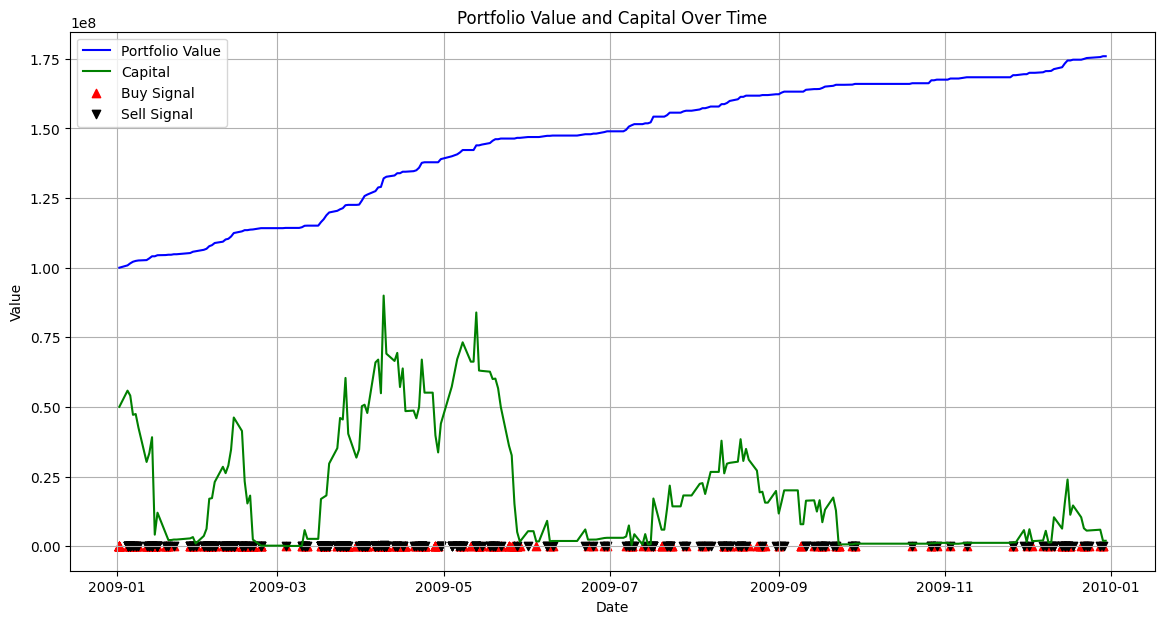

최종 포트폴리오 가치: 175909997.0
CAGR: 0.7680425601839242


In [120]:
import matplotlib.pyplot as plt
import pandas as pd

# 백테스팅 결과 시각화 함수
def plot_backtesting_results(all_trading_dates, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals):
    plt.figure(figsize=(14, 7))
    plt.plot(all_trading_dates, portfolio_values_over_time, label='Portfolio Value', color='blue')
    plt.plot(all_trading_dates, capital_over_time, label='Capital', color='green')
    buy_dates, buy_prices = zip(*buy_signals)
    plt.scatter(buy_dates, buy_prices, marker='^', color='red', label='Buy Signal')
    sell_dates, sell_prices = zip(*sell_signals)
    plt.scatter(sell_dates, sell_prices, marker='v', color='black', label='Sell Signal')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio Value and Capital Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_backtesting_results(positions_dict, total_portfolio_value, cagr):
    print(f"최종 포트폴리오 가치: {total_portfolio_value}")
    print(f"CAGR: {cagr}")
    # for ticker, positions in positions_dict.items():
    #     print(f"종목: {ticker}")
    #     for position in positions:
    #         print(f"  매수가: {position.buy_price}, 수량: {position.quantity}, 차수: {position.order}")

plot_backtesting_results(all_trading_dates, portfolio_values_over_time, capital_over_time, buy_signals, sell_signals)
analyze_backtesting_results(positions_dict, total_portfolio_value, cagr)

### 병렬 백테스팅 실행 및 결과 저장 (추후 수정예정)


In [ ]:


num_splits_options = [10] # 15,20,25,30
buy_threshold_options = [30 ] # 35, 40, 45, 50, 55, 60
investment_ratio_options = [0.15] # 0.2 , 0.25, 0.3, 0.35, 0.4, 0.45, 0.5

# combinations = [(n, b, i) for n in num_splits_options for b in buy_threshold_options for i in investment_ratio_options]
# # 결과를 DataFrame으로 변환하여 출력
# results_df = pd.DataFrame(all_results, columns=["num_splits", "buy_threshold", "investment_ratio", "Average_Total_Value", "Average_CAGR"])
# print(results_df.sort_values(by="Average_CAGR", ascending=False))


with concurrent.futures.ThreadPoolExecutor(max_workers=224) as executor:
    futures = [executor.submit(average_cagr_wrapper, param) for param in combinations]
    # results = [future.result() for future in concurrent.futures.as_completed(futures)]
    results = []
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(combinations)):
        result = future.result()
        results.append(result)

# 결과 DataFrame 생성 및 저장
results_df = pd.DataFrame(results, columns=["num_splits", "buy_threshold", "investment_ratio", "Average_Total_Value", "Average_CAGR"])
results_df.to_csv('average_backtesting_results_7_10split_2.csv', index=False)

# 결과 출력
# print(results_df.sort_values(by="Average_CAGR", ascending=False))

NameError: name 'combinations' is not defined